In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(device)

print(f"Available Device: {torch.cuda.get_device_name()}")

Available Device: Tesla P100-PCIE-16GB


In [2]:
import gc
import numpy as np

rs = 11111111

torch.manual_seed(rs)
np.random.seed(rs)

In [3]:
import os, datetime
import random

import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, det_curve,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import cv2 as cv

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        classif_labels = os.listdir(foldpath)
        

        for class_name in classif_labels:
            imgpaths = os.path.join(foldpath, class_name)
            label = class_name
            filelist_ = os.listdir(imgpaths)
            
            for file_ in filelist_:
                fpath = os.path.join(imgpaths, file_)
                filepaths.append(fpath)
                labels.append(label)

    return filepaths, labels


def get_test_df(base_dir):
    test_data = pd.read_csv(test_csv)

    X_test = []

    for image_name in test_data.new_names:
        # Loading images
        img = test_imgs + image_name
  
        X_test.append(img)
    
    # Storing target values as well 
    y_test = test_data.labels.values
    test_df = pd.DataFrame({'filepaths':X_test,'labels':y_test})
    test_df['labels'] = test_df['labels']
    return test_df


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels').apply(lambda x: 1 if x == 'all' else 0)
    return pd.concat([Fseries, Lseries], axis= 1)


# Function that create dataframe for train, validation, and test data
def create_df(data_dir):

    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    train_df, valid_df = train_test_split(df, train_size=0.8, random_state=rs)

    return train_df, valid_df

class LeukemiaDataset(Dataset):
 
    def __init__(self, df, transform=lambda x: torch.as_tensor(x)):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        img_name = self.df.iloc[idx, 0]
        
        label = self.df.iloc[idx, 1]

        return self.transform(cv.imread(img_name)),torch.as_tensor(label)

class ApplyThreshold:
    def __call__(self,image):
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

        thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
        result = cv.bitwise_and(image, image, mask=thresh)
        result[thresh==0] = [255,255,255] 
        
        (x, y, _) = np.where(result > 0)
        mnx,mxx = (np.min(x)),(np.max(x))
        mny,mxy = (np.min(y)),(np.max(y))
        
        return image[mnx:mxx,mny:mxy,:]


base_dir = '/kaggle/input/leukemia-classification'  # Replace with your directory (whatever current directory this notebook is in)
train_dir = os.path.join(base_dir, 'C-NMC_Leukemia/training_data/') # make sure this data is in the base_dir
test_csv = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_imgs = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/')

batch_size = 128

train_df, val_df = create_df(train_dir)
test_df = get_test_df(base_dir)

main_transform = transforms.Compose([
        ApplyThreshold(),
        transforms.ToTensor(),
        transforms.Resize((224,224),antialias=None)
    ])

random_transforms = transforms.RandomApply(
        torch.nn.ModuleList([
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=.5, hue=.15)
    ]),p=0.7)

#random_transforms = torch.jit.script(random_transforms)
train_transform = transforms.Compose([
    main_transform,
    random_transforms
   ])


train_dataset = LeukemiaDataset(train_df,train_transform)
val_dataset = LeukemiaDataset(val_df,main_transform)
test_dataset = LeukemiaDataset(test_df,main_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True,num_workers=4,prefetch_factor=8)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,pin_memory=True,num_workers=4,prefetch_factor=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,pin_memory=True,num_workers=4,prefetch_factor=8)


print(f"Items in Train: {len(train_dataset)}")
print(f"Items in Val: {len(val_dataset)}")
print(f"Items in Test: {len(test_dataset)}")

print("Setup complete.")

Items in Train: 8528
Items in Val: 2133
Items in Test: 1867
Setup complete.


In [4]:
del train_df
del test_df
del val_df
gc.collect()
torch.cuda.empty_cache()

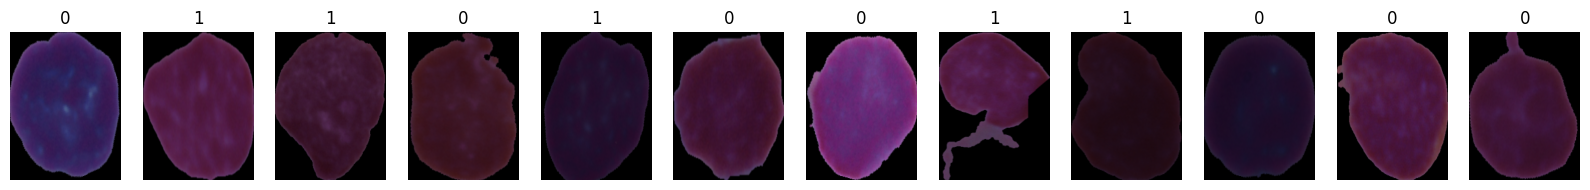

In [5]:
def visualise_images(data_generator):
    images,labels = next(iter(train_dataloader))
 
    
    batch_size = images.shape[0]
    fig, axes = plt.subplots(1, batch_size//10, figsize=(16, 2))
    axes = axes.flatten()
    
    for img,lbl, ax in zip(images[:batch_size//10],labels[:batch_size//10], axes):
        img = img.permute(1, 2, 0)
        ax.imshow(img.cpu())
        ax.set_title(lbl.item())
        ax.axis('tight')
        ax.axis('off')
        
        
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()
    

visualise_images(train_dataloader)

In [6]:
from sklearn.decomposition import PCA

  
def eval(generator_test, generator_train, generator_val, model):
    
    y_train_true,y_train_pred = get_predictions(generator_train,model)
    y_val_true,y_val_pred = get_predictions(generator_val,model)
    y_test_true, y_test_pred = get_predictions(generator_test,model)
    
    _,y_val_pred_flat_thresh = torch.max(torch.as_tensor(np.array(y_val_pred)), 1)
    _,y_test_pred_flat_thresh = torch.max(torch.as_tensor(np.array(y_test_pred)), 1)
    _,y_train_pred_flat_thresh = torch.max(torch.as_tensor(np.array(y_train_pred)), 1)
    
    cm_val = confusion_matrix(y_val_true, y_val_pred_flat_thresh)
    f1_val = f1_score(y_val_true, y_val_pred_flat_thresh)
    
    cm_test = confusion_matrix(y_test_true, y_test_pred_flat_thresh)
    f1_test = f1_score(y_test_true, y_test_pred_flat_thresh)
    
    cm_train = confusion_matrix(y_train_true, y_train_pred_flat_thresh)
    f1_train = f1_score(y_train_true, y_train_pred_flat_thresh)


    print(f"ROC-AUC score test: {roc_auc_score(y_test_true, y_test_pred, average='weighted')}\n")
    print(f"ROC-AUC score validation: {roc_auc_score(y_val_true, y_val_pred, average='weighted')}\n")
    
    print(f"Test: \n {classification_report(y_test_true, y_test_pred_flat_thresh)}")
    print(f"Val:\n {classification_report(y_val_true, y_val_pred_flat_thresh)}")
    print(f"Train:\n {classification_report(y_train_true, y_train_pred_flat_thresh)}")
    
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Test')
    plt.legend(loc='lower right')
    
    fpr_val, tpr_val, _ = roc_curve(y_val_true, y_val_pred)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Validation')
    plt.legend(loc='lower right')
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 14))
    
    
    test_fpr_det, test_fnr_det, _ = det_curve(y_test_true, y_test_pred)
    axes[1].plot(test_fpr_det, test_fnr_det)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('False Negative Rate')
    axes[1].set_title('DET Curve (Test)')
    
    val_fpr_det, val_fnr_det, _ = det_curve(y_val_true, y_val_pred)
    axes[0].plot(val_fpr_det, val_fnr_det)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('False Negative Rate')
    axes[0].set_title('DET Curve (Validation)')

    fig, axs = plt.subplots(3, 1, figsize=[10, 20])
    
    c = ConfusionMatrixDisplay(cm_test)
    c.plot(ax = axs[0])

    c = ConfusionMatrixDisplay(cm_train)
    c.plot(ax = axs[1])
    
    c = ConfusionMatrixDisplay(cm_val)
    c.plot(ax = axs[2])

    axs[0].set_title(f'Confusion Matrix for Test Set - F1-Score: {f1_test}')
    axs[0].set_xlabel('Predicted label')
    axs[0].set_ylabel('True label')
    
    axs[1].set_title(f'Confusion Matrix for Train Set - F1-Score: {f1_train}')
    axs[1].set_xlabel('Predicted label')
    axs[1].set_ylabel('True label')
    
    axs[2].set_title(f'Confusion Matrix for Validation Set - F1-Score: {f1_val}')
    axs[2].set_xlabel('Predicted label')
    axs[2].set_ylabel('True label')



In [7]:
def pairwise_distance_torch(embeddings, device):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
      embeddings: 2-D Tensor of size [number of data, feature dimension].
    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """

    # pairwise distance matrix with precise embeddings
    precise_embeddings = embeddings.to(dtype=torch.float32)

    c1 = torch.pow(precise_embeddings, 2).sum(axis=-1)
    c2 = torch.pow(precise_embeddings.transpose(0, 1), 2).sum(axis=0)
    c3 = precise_embeddings @ precise_embeddings.transpose(0, 1)

    c1 = c1.reshape((c1.shape[0], 1))
    c2 = c2.reshape((1, c2.shape[0]))
    c12 = c1 + c2
    pairwise_distances_squared = c12 - 2.0 * c3

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = torch.max(pairwise_distances_squared, torch.tensor([0.]).to(device))
    # Get the mask where the zero distances are at.
    error_mask = pairwise_distances_squared.clone()
    error_mask[error_mask > 0.0] = 1.
    error_mask[error_mask <= 0.0] = 0.

    pairwise_distances = torch.mul(pairwise_distances_squared, error_mask)

    # Explicitly set diagonals to zero.
    mask_offdiagonals = torch.ones((pairwise_distances.shape[0], pairwise_distances.shape[1])) - torch.diag(torch.ones(pairwise_distances.shape[0]))
    pairwise_distances = torch.mul(pairwise_distances.to(device), mask_offdiagonals.to(device))
    return pairwise_distances

def TripletSemiHardLoss(y_true, y_pred, device, margin=1.0):
    """Computes the triplet loss_functions with semi-hard negative mining.
       The loss_functions encourages the positive distances (between a pair of embeddings
       with the same labels) to be smaller than the minimum negative distance
       among which are at least greater than the positive distance plus the
       margin constant (called semi-hard negative) in the mini-batch.
       If no such negative exists, uses the largest negative distance instead.
       See: https://arxiv.org/abs/1503.03832.
       We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
       [batch_size] of multi-class integer labels. And embeddings `y_pred` must be
       2-D float `Tensor` of l2 normalized embedding vectors.
       Args:
         margin: Float, margin term in the loss_functions definition. Default value is 1.0.
         name: Optional name for the op.
       """

    labels, embeddings = y_true, y_pred

    # Reshape label tensor to [batch_size, 1].
    lshape = labels.shape
    labels = torch.reshape(labels, [lshape[0], 1])

    pdist_matrix = pairwise_distance_torch(embeddings, device)

    # Build pairwise binary adjacency matrix.
    adjacency = torch.eq(labels, labels.transpose(0, 1))
    # Invert so we can select negatives only.
    adjacency_not = adjacency.logical_not()

    batch_size = labels.shape[0]

    # Compute the mask.
    pdist_matrix_tile = pdist_matrix.repeat(batch_size, 1)
    adjacency_not_tile = adjacency_not.repeat(batch_size, 1)

    transpose_reshape = pdist_matrix.transpose(0, 1).reshape(-1, 1)
    greater = pdist_matrix_tile > transpose_reshape

    mask = adjacency_not_tile & greater

    # final mask
    mask_step = mask.to(dtype=torch.float32)
    mask_step = mask_step.sum(axis=1)
    mask_step = mask_step > 0.0
    mask_final = mask_step.reshape(batch_size, batch_size)
    mask_final = mask_final.transpose(0, 1)

    adjacency_not = adjacency_not.to(dtype=torch.float32)
    mask = mask.to(dtype=torch.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    axis_maximums = torch.max(pdist_matrix_tile, dim=1, keepdim=True)
    masked_minimums = torch.min(torch.mul(pdist_matrix_tile - axis_maximums[0], mask), dim=1, keepdim=True)[0] + axis_maximums[0]
    negatives_outside = masked_minimums.reshape([batch_size, batch_size])
    negatives_outside = negatives_outside.transpose(0, 1)

    # negatives_inside: largest D_an.
    axis_minimums = torch.min(pdist_matrix, dim=1, keepdim=True)
    masked_maximums = torch.max(torch.mul(pdist_matrix - axis_minimums[0], adjacency_not), dim=1, keepdim=True)[0] + axis_minimums[0]
    negatives_inside = masked_maximums.repeat(1, batch_size)

    semi_hard_negatives = torch.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = margin + pdist_matrix - semi_hard_negatives

    mask_positives = adjacency.to(dtype=torch.float32) - torch.diag(torch.ones(batch_size)).to(device)
    num_positives = mask_positives.sum()

    triplet_loss = (torch.max(torch.mul(loss_mat, mask_positives), torch.tensor([0.]).to(device))).sum() / num_positives
    triplet_loss = triplet_loss.to(dtype=embeddings.dtype)
    return triplet_loss


class TripletLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, input, target, **kwargs):
        return TripletSemiHardLoss(target, input, self.device)
    

In [8]:
from torchvision.models import ResNet50_Weights,resnet50
import torch.optim as optim

embedding_size = 64
img_size = (3,224,224)

class L2NormalizationLayer(nn.Module):
    def __init__(self, dim=1, eps=1e-12):
        super(L2NormalizationLayer, self).__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x):
        return F.normalize(x, p=2.0, dim=self.dim, eps=self.eps)


class CustomResNet50(nn.Module):
    def __init__(self, embedding_size,frozen_base=True):
        super(CustomResNet50, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.model.fc.in_features
        
        if frozen_base:
            self.freeze_base()
                
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, embedding_size),
            nn.Dropout(p=0.5),
            L2NormalizationLayer()
        )

    def forward(self, x):
        return self.model(x)
    
    def freeze_base(self):
        for param in self.model.parameters():
                param.grad = None

                
model = CustomResNet50(embedding_size).to(device)
   
optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-2)
loss_function = TripletLoss(device=device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s] 


In [9]:
torch.autograd.set_detect_anomaly(mode=False)
torch.autograd.profiler.emit_nvtx(enabled=False)

torch.backends.cudnn.benchmark = True
#torch.set_float32_matmul_precision("high")
torch.jit.enable_onednn_fusion(True)
#torch.set_flush_denormal(True)

In [10]:
from torch.cuda.amp import autocast, GradScaler
import time
# To observe convergence behaviour
def train_single_batch(model, num_epochs,optimizer):
    images,labels = next(iter(train_dataloader))
    scaler = GradScaler()

    for epoch in range(num_epochs):
        start = time.time()
        
        model.train()
        
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(dtype=torch.float16):
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
     
        
        end_train = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Train Time: {end_train-start:.4f}")
train_single_batch(model,30,optimizer)
        

Epoch [1/30], Loss: 0.9762, Train Time: 20.2204
Epoch [2/30], Loss: 0.9745, Train Time: 0.5260
Epoch [3/30], Loss: 0.9672, Train Time: 0.5236
Epoch [4/30], Loss: 0.9613, Train Time: 0.5223
Epoch [5/30], Loss: 0.9433, Train Time: 0.5230
Epoch [6/30], Loss: 0.9174, Train Time: 0.5218
Epoch [7/30], Loss: 0.8902, Train Time: 0.5246
Epoch [8/30], Loss: 0.8652, Train Time: 0.5246
Epoch [9/30], Loss: 0.8491, Train Time: 0.5230
Epoch [10/30], Loss: 0.7758, Train Time: 0.5215
Epoch [11/30], Loss: 0.7606, Train Time: 0.5214
Epoch [12/30], Loss: 0.7339, Train Time: 0.5224
Epoch [13/30], Loss: 0.7355, Train Time: 0.5232
Epoch [14/30], Loss: 0.6715, Train Time: 0.5223
Epoch [15/30], Loss: 0.6411, Train Time: 0.5239
Epoch [16/30], Loss: 0.5633, Train Time: 0.5226
Epoch [17/30], Loss: 0.5622, Train Time: 0.5230
Epoch [18/30], Loss: 0.5553, Train Time: 0.5228
Epoch [19/30], Loss: 0.4840, Train Time: 0.5227
Epoch [20/30], Loss: 0.4572, Train Time: 0.5225
Epoch [21/30], Loss: 0.4717, Train Time: 0.5225


In [11]:
from torch.cuda.amp import autocast, GradScaler
import time

def train(model, num_epochs,optimizer):
    scaler = GradScaler()
    best_val_loss=float('inf')
    

    for epoch in range(num_epochs):
        start = time.time()
        
        train_loss =0.0

        model.train()
        
        
        for images,labels in train_dataloader:
            images, labels = images.to(device,non_blocking=True), labels.to(device,non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            
            with autocast(dtype=torch.float16):
                outputs = model(images)
                loss = loss_function(outputs, labels)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        train_loss /= len(train_dataloader)
        end_train = time.time()
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for images,labels in val_dataloader:
                images, labels = images.to(device,non_blocking=True), labels.to(device,non_blocking=True)
               
                with autocast(dtype=torch.float16):
                    outputs = model(images)
                    loss = loss_function(outputs, labels)
                    
                val_loss += loss.item()
            
        val_loss /= len(val_dataloader)
        
        if val_loss < best_val_loss:
            best_val_loss=val_loss
            torch.save(model.state_dict(), 'best-model-parameters.pt')
        
        
        end_val = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Time: {end_train-start:.4f}, Inference Time: {end_val-end_train:.4f}")


In [12]:
train(model,10,optimizer)

Epoch [1/10], Loss: 0.9267, Val Loss: 0.9588, Train Time: 107.0808, Inference Time: 19.8956
Epoch [2/10], Loss: 0.8941, Val Loss: 0.7270, Train Time: 79.9520, Inference Time: 13.0476
Epoch [3/10], Loss: 0.8550, Val Loss: 0.8460, Train Time: 80.2682, Inference Time: 12.8945
Epoch [4/10], Loss: 0.8591, Val Loss: 0.7848, Train Time: 81.3504, Inference Time: 12.8424
Epoch [5/10], Loss: 0.8398, Val Loss: 0.9654, Train Time: 81.3190, Inference Time: 12.9918
Epoch [6/10], Loss: 0.8313, Val Loss: 0.6235, Train Time: 81.1893, Inference Time: 13.8336
Epoch [7/10], Loss: 0.8182, Val Loss: 0.7063, Train Time: 81.1440, Inference Time: 13.2457
Epoch [8/10], Loss: 0.8076, Val Loss: 0.8659, Train Time: 79.6312, Inference Time: 13.1498
Epoch [9/10], Loss: 0.7812, Val Loss: 0.9840, Train Time: 79.8442, Inference Time: 13.2054
Epoch [10/10], Loss: 0.7768, Val Loss: 0.7887, Train Time: 80.3451, Inference Time: 12.9787


In [13]:
state_dict = torch.load('best-model-parameters.pt')
best_m = CustomResNet50(embedding_size,frozen_base=False)
best_m = best_m.load_state_dict(state_dict)

optimizer = optim.Adam(model.parameters(),lr=1e-6, weight_decay=1e-2)
train(model,20,optimizer)


Epoch [1/20], Loss: 0.7757, Val Loss: 0.6272, Train Time: 80.7229, Inference Time: 13.3343
Epoch [2/20], Loss: 0.7439, Val Loss: 0.5826, Train Time: 80.9213, Inference Time: 13.3031
Epoch [3/20], Loss: 0.7119, Val Loss: 0.5887, Train Time: 81.1305, Inference Time: 12.8859
Epoch [4/20], Loss: 0.7061, Val Loss: 0.5515, Train Time: 80.1946, Inference Time: 13.4309
Epoch [5/20], Loss: 0.6784, Val Loss: 0.6102, Train Time: 81.8584, Inference Time: 12.8586
Epoch [6/20], Loss: 0.6784, Val Loss: 0.5799, Train Time: 81.8400, Inference Time: 13.2361
Epoch [7/20], Loss: 0.6528, Val Loss: 0.5617, Train Time: 80.0034, Inference Time: 12.9581
Epoch [8/20], Loss: 0.6348, Val Loss: 0.6302, Train Time: 79.5068, Inference Time: 13.2250
Epoch [9/20], Loss: 0.6475, Val Loss: 0.5392, Train Time: 82.2429, Inference Time: 13.8358
Epoch [10/20], Loss: 0.6735, Val Loss: 0.5591, Train Time: 82.6557, Inference Time: 13.3097
Epoch [11/20], Loss: 0.6482, Val Loss: 0.5415, Train Time: 80.5460, Inference Time: 13.65

In [14]:
state_dict = torch.load('best-model-parameters.pt')
best_m = CustomResNet50(embedding_size,frozen_base=False)
best_m = best_m.load_state_dict(state_dict)

In [15]:
from sklearn.manifold import TSNE

def prelim_performance(y_train, X_train,y_test, X_test):
    y_train,X_train = np.array(y_train),np.array(X_train)
    y_test,X_test = np.array(y_test),np.array(X_test)
    
    clf = KNeighborsClassifier(n_jobs=-1)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1_kn  = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1_kn}")
    
    
    tsne_embeddings = TSNE(random_state=rs,n_jobs=-1).fit_transform(X_train)
    fig = plt.figure(figsize=[24, 24])
    ax = fig.add_subplot(2, 1, 1)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_train.flatten());
    tsne_embeddings = TSNE(random_state=rs,n_jobs=-1).fit_transform(X_test)
    ax = fig.add_subplot(2, 1, 2)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());
    
    
# Loads all preds and true into memory not ideal but doable in this case
def get_predictions(data_generator,model):
    y_true,y_pred = [],[]
    

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            
            pred_batch = model(X_batch).cpu()
            
            y_pred.extend(pred_batch)
            y_true.extend(y_batch)
       
    
    return y_true,y_pred


In [16]:
y_train,X_train = get_predictions(train_dataloader,model)

In [17]:
y_test,X_test = get_predictions(test_dataloader,model)

In [18]:
y_val,X_val = get_predictions(val_dataloader,model)

Accuracy: 0.7905731119442957
F1: 0.8513873052071457


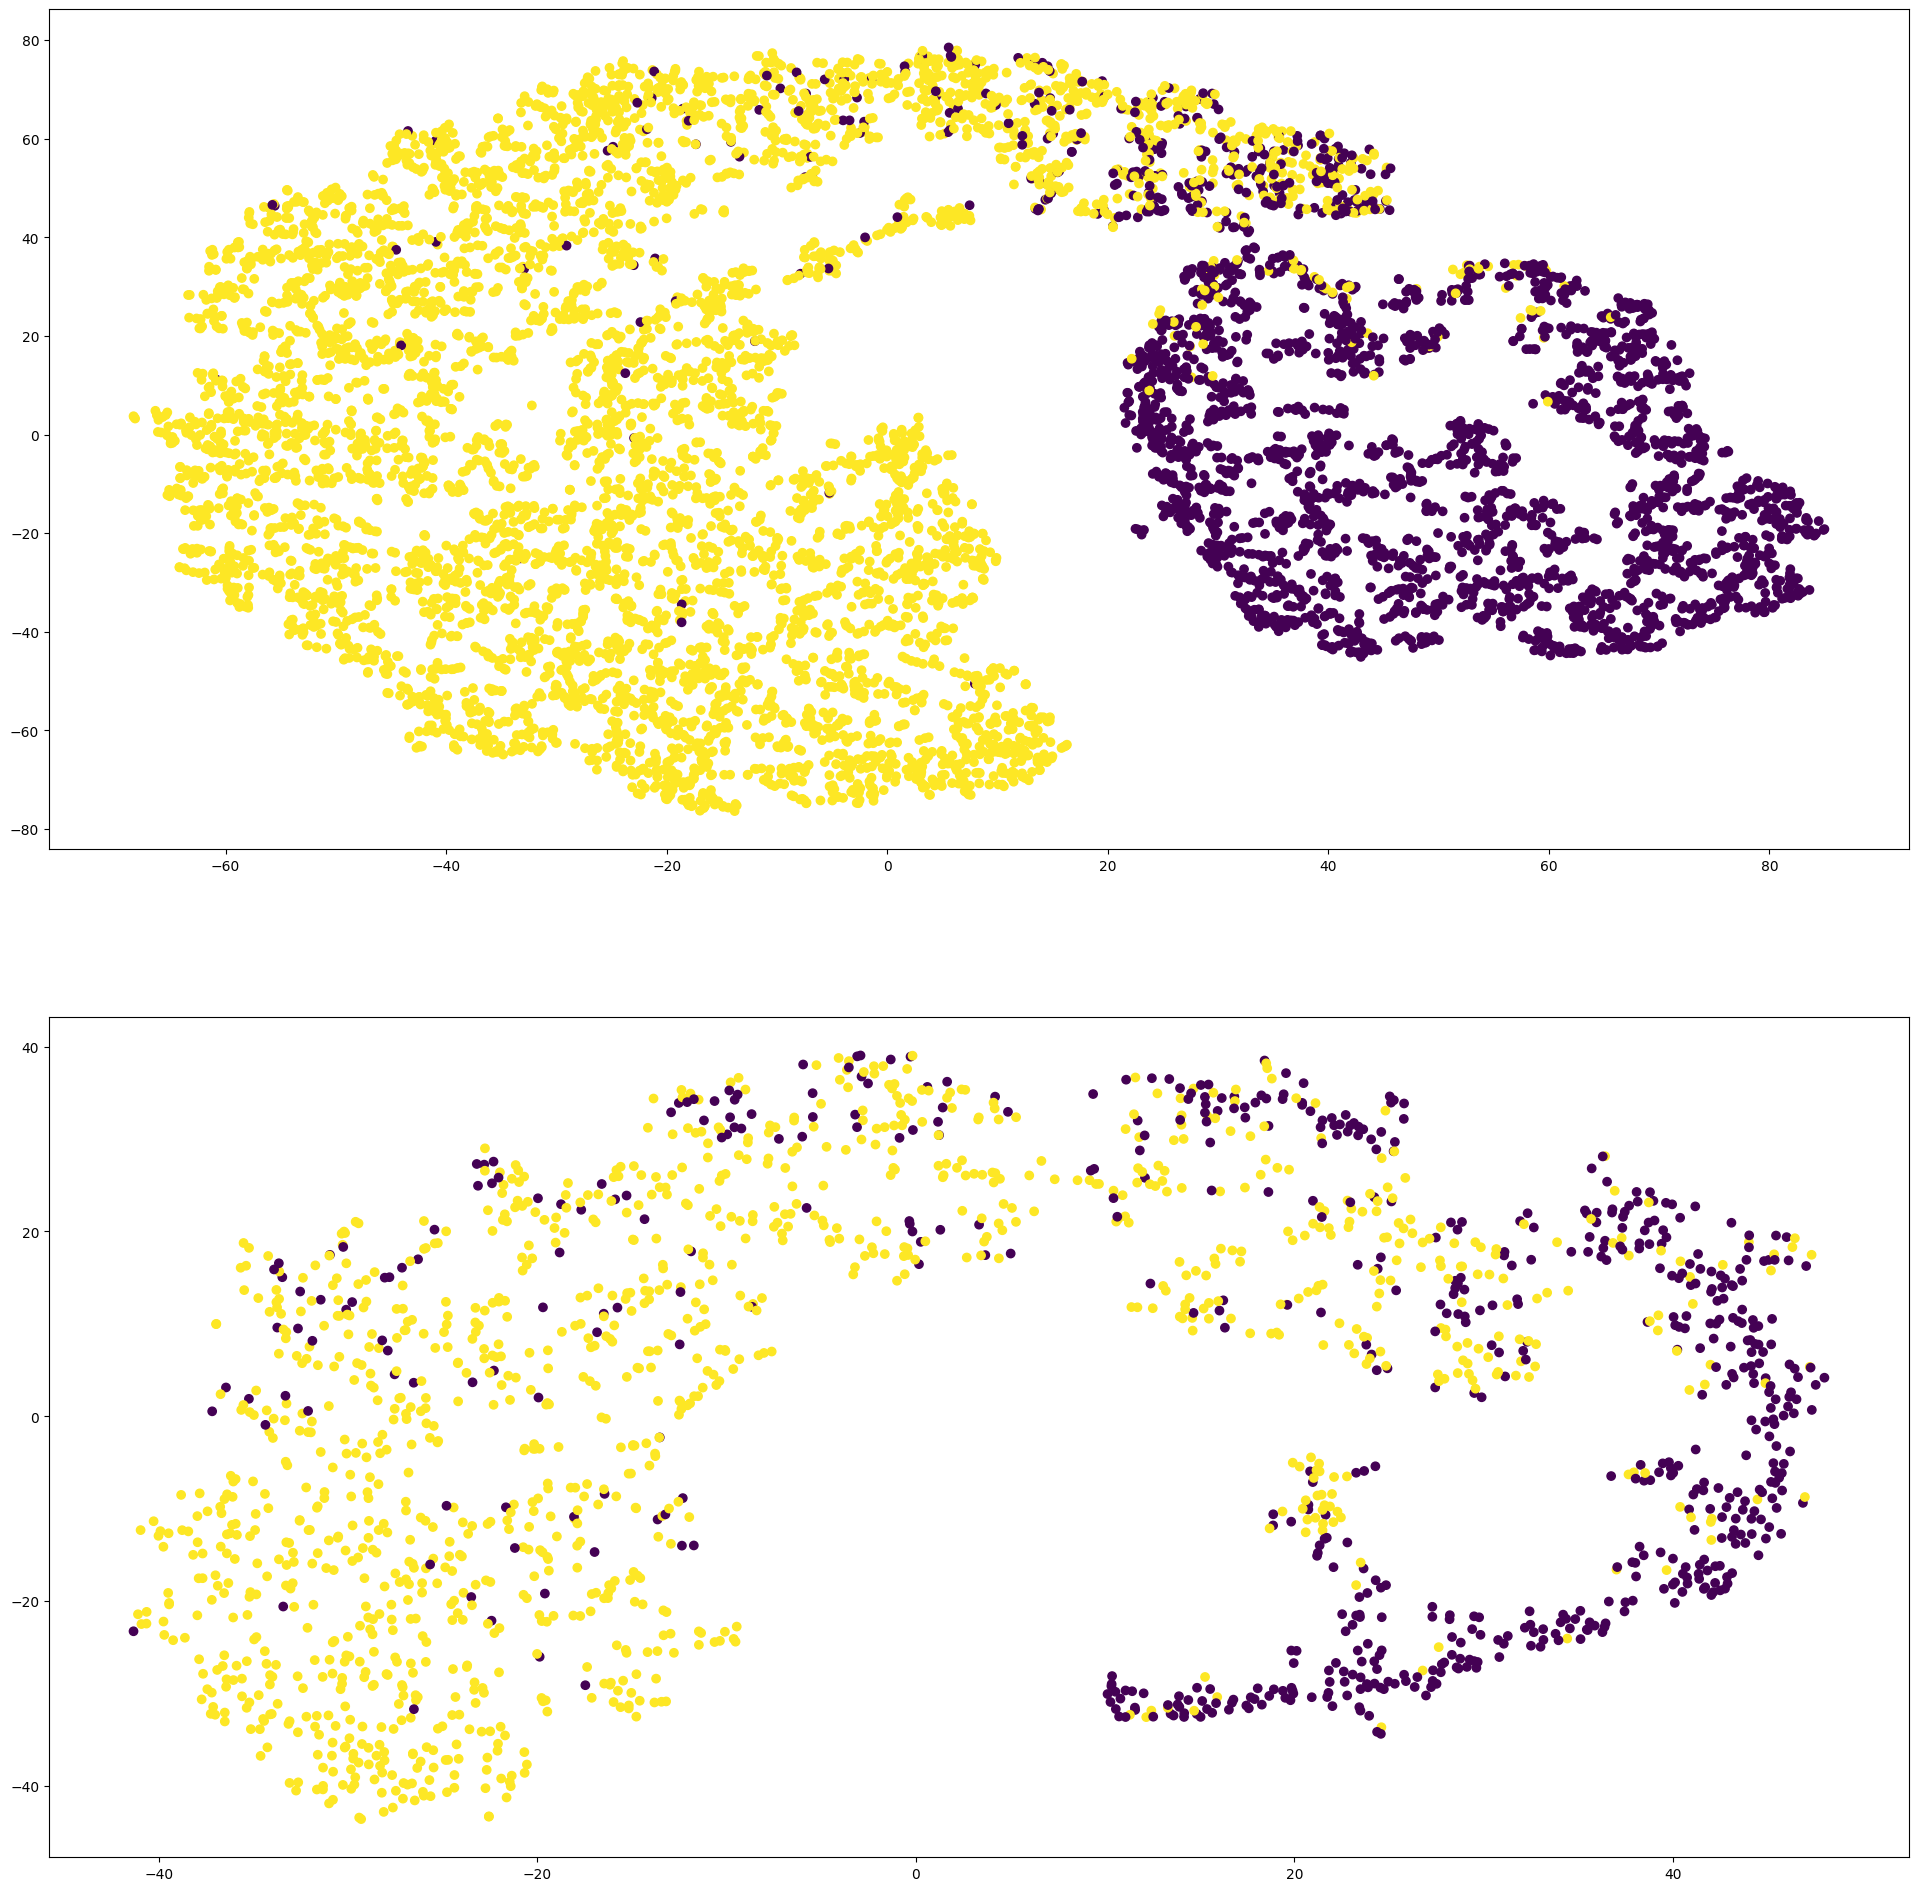

In [19]:
prelim_performance(y_train, X_train,y_test, X_test)

In [20]:
torch.save(X_train, 'X_train_embed.pt')
torch.save(y_train, 'y_train_embed.pt')

torch.save(X_test, 'X_test_embed.pt')
torch.save(y_test, 'y_test_embed.pt')

torch.save(X_val, 'X_val_embed.pt')
torch.save(y_val, 'y_val_embed.pt')

In [21]:
del X_train
del y_train
del X_val
del y_val
del X_test
del y_test
gc.collect()

0

In [22]:
def train_classif(model, num_epochs,optimizer,train_dataloader,val_dataloader,loss_function):
    scaler = GradScaler()
    best_val_loss=float('inf')
    

    for epoch in range(num_epochs):
        start = time.time()
        
        train_loss =0.0
        correct_train = 0
        total_train = 0

        model.train()
        
        
        for X,y in train_dataloader:
            X, y = X.to(device,non_blocking=True), y.to(device,non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            
            with autocast(dtype=torch.float16):
                outputs = model(X)
                loss = loss_function(outputs, y)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += y.size(0)
            correct_train += (predicted == y).sum().item()
        
        train_loss /= len(train_dataloader)
        correct_train /= total_train
        
        end_train = time.time()
        
        model.eval()
        val_loss = 0.0
        correct_val = 0.0
        total_val = 0.0
        
        with torch.no_grad():
            for X,y in val_dataloader:
                X, y = X.to(device,non_blocking=True),  y.to(device,non_blocking=True)
               
                with autocast(dtype=torch.float16):
                    outputs = model(X)
                    loss = loss_function(outputs,y)
                    
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += y.size(0)
                correct_val += (predicted == y).sum().item()
                
        val_loss /= len(val_dataloader)
        correct_val /= total_val
        
        if val_loss < best_val_loss:
            best_val_loss=val_loss
            torch.save(model.state_dict(), 'best-model-parameters-classif.pt')
        
        
        end_val = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {correct_train:.4f},Val Accuracy: {correct_val:.4f}, Train Time: {end_train-start:.4f}, Inference Time: {end_val-end_train:.4f}")


In [23]:
class EmbeddingsDataset(Dataset):
 
    def __init__(self, X_path,y_path):
        self.embeddings = torch.load(X_path)
        self.labels = torch.load(y_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [24]:
class CustomClassifier(nn.Module):
    def __init__(self,embedding_size):
        super(CustomClassifier, self).__init__()
        
                
        self.model = nn.Sequential(
            nn.Linear(embedding_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        return self.model(x)

In [25]:
train_embed = EmbeddingsDataset('X_train_embed.pt','y_train_embed.pt')
val_embed = EmbeddingsDataset('X_val_embed.pt','y_val_embed.pt')
test_embed = EmbeddingsDataset('X_test_embed.pt','y_test_embed.pt')

train_embed_dataloader = DataLoader(train_embed, batch_size=batch_size, shuffle=True,pin_memory=True,num_workers=4,prefetch_factor=8)
val_embed_dataloader = DataLoader(val_embed, batch_size=batch_size, shuffle=True,pin_memory=True,num_workers=4,prefetch_factor=8)
test_embed_dataloader = DataLoader(test_embed, batch_size=batch_size, shuffle=True,pin_memory=True,num_workers=4,prefetch_factor=8)



In [26]:
classifier = CustomClassifier(embedding_size)
loss_function_classif = nn.CrossEntropyLoss()
optimizer_classif = optim.Adam(classifier.parameters(), lr=0.1)
classifier = classifier.to(device)

In [27]:
train_classif(classifier, 20,optimizer_classif,train_embed_dataloader,val_embed_dataloader,loss_function_classif)

Epoch [1/20], Loss: 7.6799, Val Loss: 0.1402, Train Accuracy: 0.8547,Val Accuracy: 0.9517, Train Time: 0.5294, Inference Time: 0.1777
Epoch [2/20], Loss: 0.1293, Val Loss: 0.1417, Train Accuracy: 0.9524,Val Accuracy: 0.9592, Train Time: 0.4635, Inference Time: 0.1680
Epoch [3/20], Loss: 0.1170, Val Loss: 0.1241, Train Accuracy: 0.9558,Val Accuracy: 0.9620, Train Time: 0.4591, Inference Time: 0.1705
Epoch [4/20], Loss: 0.1160, Val Loss: 0.1299, Train Accuracy: 0.9560,Val Accuracy: 0.9536, Train Time: 0.4549, Inference Time: 0.1739
Epoch [5/20], Loss: 0.1184, Val Loss: 0.1397, Train Accuracy: 0.9527,Val Accuracy: 0.9602, Train Time: 0.4596, Inference Time: 0.1684
Epoch [6/20], Loss: 0.1186, Val Loss: 0.1375, Train Accuracy: 0.9545,Val Accuracy: 0.9602, Train Time: 0.5030, Inference Time: 0.2038
Epoch [7/20], Loss: 0.1118, Val Loss: 0.1406, Train Accuracy: 0.9568,Val Accuracy: 0.9616, Train Time: 0.5403, Inference Time: 0.1926
Epoch [8/20], Loss: 0.1153, Val Loss: 0.1224, Train Accuracy: 

In [ ]:
with torch.no_grad():
    eval(test_embed_dataloader, train_embed_dataloader, val_embed_dataloader, classifier)